<a href="https://colab.research.google.com/github/serinamarie/DS-Unit-2-Regression-Classification/blob/master/Grill_assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3 - UNFINISHED#

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

##Import and Clean Data (somewhat)##

In [184]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

Requirement already up-to-date: category_encoders in /usr/local/lib/python3.6/dist-packages (2.0.0)
Requirement already up-to-date: pandas-profiling in /usr/local/lib/python3.6/dist-packages (2.3.0)
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
Reinitialized existing Git repository in /content/.git/
fatal: remote origin already exists.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
Already up to date.


In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='pandas')

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np

# Read New York City property sales data
data = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
data.columns = [col.replace(' ', '_') for col in data]
data.columns = data.columns.str.lower()

#Remove extreme outliers


# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
data['sale_price'] = (
    data['sale_price']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [187]:
data[(data['borough'] == 1) & (data['building_class_category'] == '01 ONE FAMILY DWELLINGS')]

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
469,1,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1917,121,NaN,A9,123 W 132 STREET,NaN,10027.0,1.0,0.0,1.0,"1,699",3400.0,1910.0,1,A9,2230000,01/04/2019
486,1,UPPER EAST SIDE (59-79),01 ONE FAMILY DWELLINGS,1,1397,23,NaN,S1,143 EAST 62ND STREET,NaN,10065.0,1.0,1.0,2.0,"1,170",3120.0,1910.0,1,S1,0,01/04/2019
2417,1,UPPER EAST SIDE (59-79),01 ONE FAMILY DWELLINGS,1,1398,5,NaN,A4,101 EAST 63RD STREET,NaN,10065.0,1.0,0.0,1.0,"2,510",7349.0,1970.0,1,A4,18000000,01/15/2019
2962,1,GREENWICH VILLAGE-WEST,01 ONE FAMILY DWELLINGS,1,625,14,NaN,A4,613 HUDSON STREET,NaN,10014.0,1.0,0.0,1.0,600,2080.0,1899.0,1,A4,5100000,01/17/2019
3612,1,GREENWICH VILLAGE-WEST,01 ONE FAMILY DWELLINGS,1,593,41,NaN,S1,22 CHRISTOPHER STREET,NaN,10014.0,1.0,1.0,2.0,"1,235",2739.0,1910.0,1,S1,5500000,01/21/2019
3986,1,HARLEM-CENTRAL,01 ONE FAMILY DWELLINGS,1,1903,25,NaN,A4,109 WEST 118 STREET,NaN,10026.0,1.0,0.0,1.0,"2,018",4480.0,1910.0,1,A4,0,01/23/2019
4001,1,MURRAY HILL,01 ONE FAMILY DWELLINGS,1,885,65,NaN,A4,155 LEXINGTON AVENUE,NaN,10016.0,1.0,0.0,1.0,"1,500",4125.0,1910.0,1,A4,4400000,01/23/2019
5380,1,GREENWICH VILLAGE-WEST,01 ONE FAMILY DWELLINGS,1,626,44,NaN,S0,37 8TH AVENUE,NaN,10014.0,1.0,2.0,3.0,803,5803.0,1901.0,1,S0,4900000,01/29/2019
6098,1,UPPER EAST SIDE (59-79),01 ONE FAMILY DWELLINGS,1,1426,140,NaN,A4,216 EAST 72ND STREET,NaN,10021.0,1.0,0.0,1.0,"1,822",3457.0,1901.0,1,A4,8850000,01/31/2019
6480,1,GREENWICH VILLAGE-CENTRAL,01 ONE FAMILY DWELLINGS,1,576,64,NaN,A4,45 WEST 12TH STREET,NaN,10011.0,1.0,0.0,1.0,"1,024",1656.0,1901.0,1,A4,6600000,02/01/2019


In [0]:
data['sale_date'] = pd.to_datetime(data['sale_date'], infer_datetime_format=True)

##Subset Data##
to one family dwellings where sale price is more than 100,000 & less than 2 million dollars

In [0]:
df = data[(data['building_class_category'] == '01 ONE FAMILY DWELLINGS'
) & (data['sale_price'] > 100000) & (data['sale_price'] < 2000000)]

##Split data into train & test##

In [190]:
df['sale_date'].dt.month.value_counts()

1    947
3    799
2    761
4    644
Name: sale_date, dtype: int64

In [0]:
#Use Jan-Mar to train, April to test
train = df[df['sale_date'].dt.month < 4]
test = df[df['sale_date'].dt.month == 4]

In [192]:
train.shape, test.shape

((2507, 21), (644, 21))

##Explore Data & Visualize##

In [193]:
corr_matrix = train.corr()
corr_matrix['sale_price'].sort_values(ascending=False)

sale_price                   1.000000
gross_square_feet            0.454418
zip_code                     0.205550
total_units                  0.149575
commercial_units             0.123074
residential_units            0.087763
year_built                  -0.037376
lot                         -0.047241
borough                     -0.065355
block                       -0.147684
ease-ment                         NaN
tax_class_at_time_of_sale         NaN
Name: sale_price, dtype: float64

In [194]:
import plotly.express as px
px.scatter(
    train,
    x = 'gross_square_feet',
    y = 'sale_price',
    color = 'borough'
)

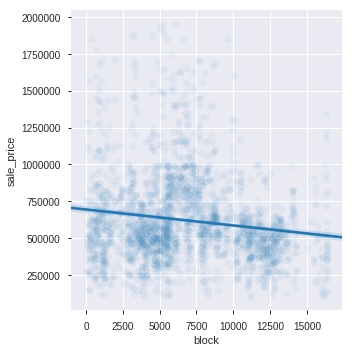

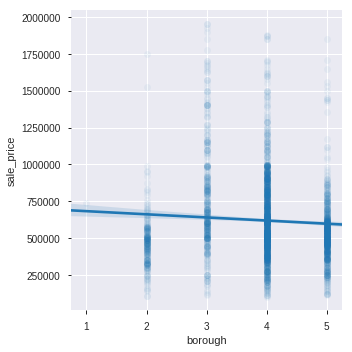

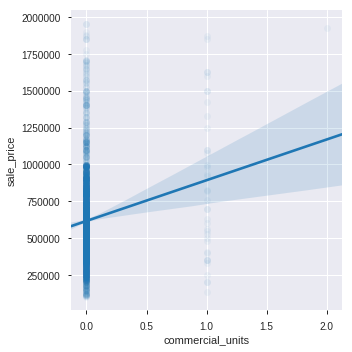

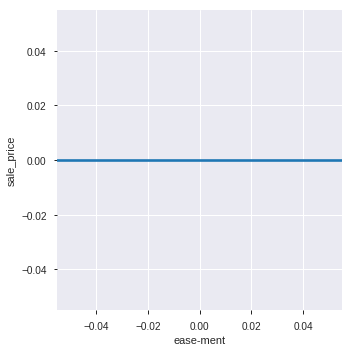

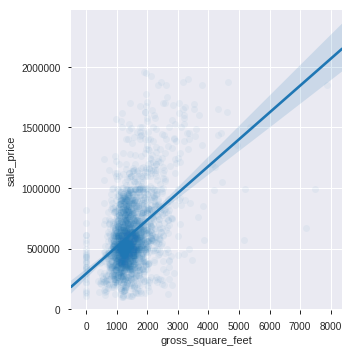

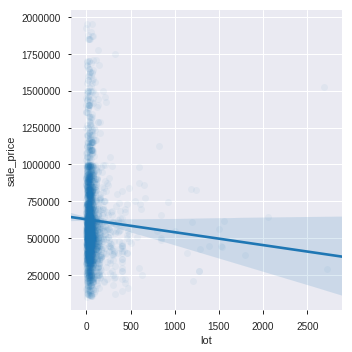

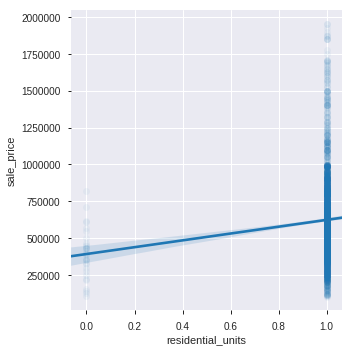

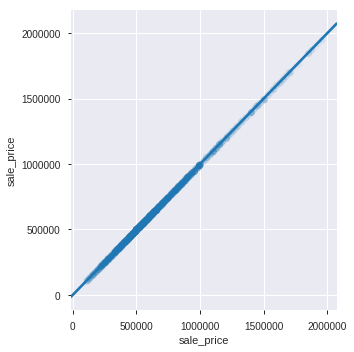

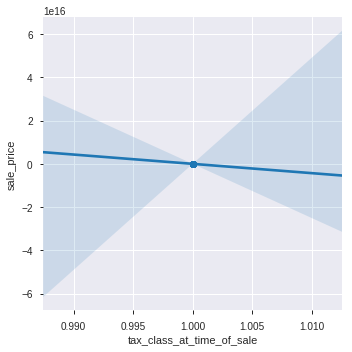

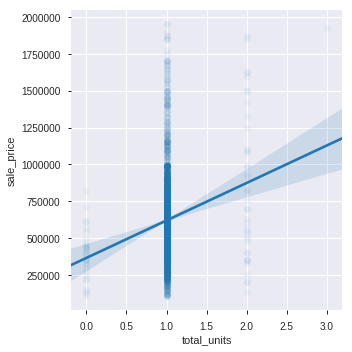

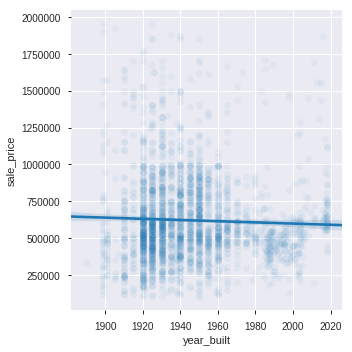

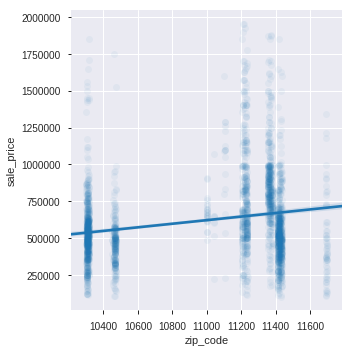

In [195]:
#Look for sale price patterns visually
import seaborn as sns
import matplotlib.pyplot as plt
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y='sale_price', data=train, scatter_kws= dict(alpha=0.05))

In [0]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset = test.select_dtypes('number').dropna(axis='columns')

In [0]:
target = 'sale_price'
features = train_subset.columns.drop([target, 'borough'])
X_train = train_subset[features]
y_train = train_subset[target]
X_test = test_subset[features]
y_test = test_subset[target]

In [0]:
#apply selectkbest method - select the best features
#taking one feature (the univariate) and seeing how it compares to the target

In [0]:
from sklearn.feature_selection import SelectKBest, f_regression
#f_regression is a univariate regression test

In [200]:
selector = SelectKBest(score_func=f_regression, k=4)

#.fit_transform on train set
#.transform on test set
#feature selection is based on training data
#then apply it to the test set to predict the y
X_train_selected = selector.fit_transform(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



In [0]:
X_test_selected = selector.transform(X_test)


#'transform' from many columns to selected number of columns (3)

In [202]:
#Which features were selected? The selected are arrays now
feature_names = X_train.columns
selected_mask = selector.get_support()
selected_features = feature_names[selected_mask]
selected_features

Index(['block', 'zip_code', 'total_units', 'gross_square_feet'], dtype='object')

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
#See which combination of features works best

for k in range(1,len(X_train.columns) + 1):
    print(f'{k},features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f}')

1,features
Test MAE: $183,641
2,features
Test MAE: $184,003
3,features
Test MAE: $183,943
4,features
Test MAE: $167,050
5,features
Test MAE: $167,908
6,features
Test MAE: $167,908
7,features
Test MAE: $167,913
8,features
Test MAE: $167,705
9,features
Test MAE: $167,705


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encou

In [205]:
train['borough'] = train['borough'].map({1:'Manhattan', 2:'Bronx', 3:'Brooklyn', 4:'Queens', 5:'Staten_Island'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [206]:
test['borough'] = test['borough'].map({1:'Manhattan', 2:'Bronx', 3:'Brooklyn', 4:'Queens', 5:'Staten_Island'})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [207]:
train.head()

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,ease-ment,building_class_at_present,address,apartment_number,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of_sale,sale_price,sale_date
44,Brooklyn,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,Queens,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
78,Bronx,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,Brooklyn,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,Brooklyn,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02


In [0]:
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['borough'])

encoded2 = encoder.fit_transform(test['borough'])
encoder2 = ce.OneHotEncoder(use_cat_names=True)
encoded_building = encoder2.fit_transform(train['building_class_at_time_of_sale'])
encoded_building2 = encoder2.fit_transform(train['building_class_at_time_of_sale'])

In [209]:
EB_test = encoded_building.join(train[['gross_square_feet','sale_price']])
EB_train = encoded_building2.join(train[['gross_square_feet','sale_price']])
EB_test.head()

,building_class_at_time_of_sale_A9,building_class_at_time_of_sale_A1,building_class_at_time_of_sale_A5,building_class_at_time_of_sale_A0,building_class_at_time_of_sale_A2,building_class_at_time_of_sale_A3,building_class_at_time_of_sale_S1,building_class_at_time_of_sale_A4,building_class_at_time_of_sale_A6,building_class_at_time_of_sale_A8,building_class_at_time_of_sale_S0,gross_square_feet,sale_price
44,1,0,0,0,0,0,0,0,0,0,0,1325.0,550000
61,0,1,0,0,0,0,0,0,0,0,0,2001.0,200000
78,0,1,0,0,0,0,0,0,0,0,0,2043.0,810000
108,0,1,0,0,0,0,0,0,0,0,0,2680.0,125000
111,0,0,1,0,0,0,0,0,0,0,0,1872.0,620000


In [0]:
encoded_test = encoded.join(train[['gross_square_feet','sale_price']])

In [0]:
encoded_train = encoded.join(train[['sale_price','gross_square_feet']])

In [212]:
encoded_test[encoded_test['borough_Manhattan'] == 1]

,borough_Brooklyn,borough_Queens,borough_Bronx,borough_Staten_Island,borough_Manhattan,gross_square_feet,sale_price
12816,0,0,0,0,1,1440.0,739000


In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
features = ['gross_square_feet', 'borough_Bronx','borough_Brooklyn','borough_Queens','borough_Staten_Island','borough_Manhattan']
target = 'sale_price'
X_train = encoded_train[features]
y_train = encoded_train[target]
X_test = encoded_test[features]
y_test = encoded_test[target]

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [232]:
mean_absolute_error(y_test, y_pred_test)

178735.33928973528

In [233]:
EB_train.columns

Index(['building_class_at_time_of_sale_A9',
       'building_class_at_time_of_sale_A1',
       'building_class_at_time_of_sale_A5',
       'building_class_at_time_of_sale_A0',
       'building_class_at_time_of_sale_A2',
       'building_class_at_time_of_sale_A3',
       'building_class_at_time_of_sale_S1',
       'building_class_at_time_of_sale_A4',
       'building_class_at_time_of_sale_A6',
       'building_class_at_time_of_sale_A8',
       'building_class_at_time_of_sale_S0', 'gross_square_feet', 'sale_price'],
      dtype='object')

In [215]:
model.coef_

array([    225.61924   , -166294.25249462,  126350.57213299,
         29118.71339303, -104624.50971367,  115449.47668226])

In [216]:
model.intercept_

298658.81771398603

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [218]:
mae_test = mean_absolute_error(y_test, y_pred_test)
mae

167704.58795917808

In [219]:
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_train

178735.33928973528

In [220]:
r2_test = r2_score(y_test, y_pred_test)
r2_test

0.3054091151595717

In [221]:
from sklearn.preprocessing import StandardScaler
target = 'sale_price'
high_cardinality = ['address','block', 'land_square_feet', 'sale_date', 'building_class_at_time_of_sale', 'neighborhood', 'building_class_at_present']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train_encoded.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)

    model= LinearRegression()
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.02f} \n')

1 features


/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:747: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/utils/extmath.py:688: RuntimeWarning:

Degrees of freedom <= 0 for slice.



ValueError: ignored

In [0]:
train_objs_num = len(train)
dataset = pd.concat(objs=[train, test], axis=0)
dums = pd.get_dummies(dataset['neighborhood'])
train_dums = dums[:train_objs_num].join(dataset[:train_objs_num])
test_dums = dums[train_objs_num:].join(dataset[train_objs_num:])

In [0]:
train_dums = train_dums.select_dtypes('number').drop(columns='ease-ment')
test_dums = test_dums.select_dtypes('number').drop(columns='ease-ment')

In [0]:
y_train.shape

In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
target = 'sale_price'

encoded_train.head()


In [0]:
r2_score(y_test,y_pred_test)

In [225]:
EB_train.head()

,building_class_at_time_of_sale_A9,building_class_at_time_of_sale_A1,building_class_at_time_of_sale_A5,building_class_at_time_of_sale_A0,building_class_at_time_of_sale_A2,building_class_at_time_of_sale_A3,building_class_at_time_of_sale_S1,building_class_at_time_of_sale_A4,building_class_at_time_of_sale_A6,building_class_at_time_of_sale_A8,building_class_at_time_of_sale_S0,gross_square_feet,sale_price
44,1,0,0,0,0,0,0,0,0,0,0,1325.0,550000
61,0,1,0,0,0,0,0,0,0,0,0,2001.0,200000
78,0,1,0,0,0,0,0,0,0,0,0,2043.0,810000
108,0,1,0,0,0,0,0,0,0,0,0,2680.0,125000
111,0,0,1,0,0,0,0,0,0,0,0,1872.0,620000


In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
target = 'sale_price'
features = ['gross_square_feet', 
            'building_class_at_time_of_sale_A9',
            'building_class_at_time_of_sale_A1', 
            'building_class_at_time_of_sale_A5',
            'building_class_at_time_of_sale_A0',
       'building_class_at_time_of_sale_A2',
       'building_class_at_time_of_sale_A3',
       'building_class_at_time_of_sale_S1',
       'building_class_at_time_of_sale_A4',
       'building_class_at_time_of_sale_A6',
       'building_class_at_time_of_sale_A8',
       'building_class_at_time_of_sale_S0',]
X_train = EB_train[features]
y_train = EB_train[target]
X_test = EB_test[features]
y_test = EB_test[target]

model.fit(X_train, y_train)
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

In [236]:
r2_score(y_test,y_pred_test)

0.23976185990624344

In [237]:
mean_absolute_error(y_test, y_pred_test)

186932.4694877709